# Decent Planner

## 下降规划器

## Thrust vector is locked to anti-velocity vector

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
dry_mass = 863 #Dry mass, in kilo gram
wet_mass = 1863 #Wet mass, including fuel
thrust = 7520 #Max thrust of spacecraft, in Newton
Isp = 320 #Isp, gravity measure, unit: second
g = 1.633 #g for landing planet. meter per second square
R = 1737100 #Radius of landing planet, meter

In [ ]:
pv = 1605 #parallel velocity, meter per second, no direction needed
vv = -122.66 #vertical velocity towards space, meter per second
altitude = 223547 #current altitude, meter

In [ ]:
tolerance_velocity = 20 #acceptable velocity when touch the ground, meter per second
terminal_altitude = 100 #When altitude is lower than terminal, the spacecraft will be considered "touch the ground"

In [ ]:
def throttle(H,altitude):
    #throttle at altitude H
    if altitude <= H:
        return thrust
    return 0

In [ ]:
def loss(H,pv,vv,altitude,wet_mass):
    # "Grade" to parameter H
    # L: Land
    # E: Escape
    # C: Crash
    # A: Early Ascent
    # O: Out of fuel
    t = 0
    t_step = 0.1
    distance = 0
    
    while True:
        t += t_step
        Ft = throttle(H,altitude)
        angle = np.arctan2(vv,pv)
        acc_front = (-1 * Ft * np.cos(angle))/wet_mass
        pv += acc_front * t_step
        acc_vert = (-1 * Ft * np.sin(angle) - wet_mass * g + (pv**2*wet_mass/R)) / wet_mass
        vv += acc_vert * t_step
        
        altitude += vv*t_step
        distance += pv*t_step
        
        wet_mass -= (throttle(H,altitude) * t_step) / (Isp*9.8)
        
        if t > 3600:
            #escape
            return 'E'
        if altitude < terminal_altitude:
            terminal = (pv**2+vv**2)**0.5
            if terminal <= tolerance_velocity:
                return 'L'
            else:
                return 'C'
        if wet_mass < dry_mass:
            return 'O'
        if throttle(H,altitude) > 0 and vv > 0:
            return 'A'

def loss_dH(result):
    if result not in "ELCOA":
        assert False, "What are you doing?"
    d = {'A':-100,'E':1,'L':0,'C':1,'O':0}
    return d[result]

In [ ]:
def gradient(H0):
    H = H0
    H_grade = loss(H,pv,vv,altitude,wet_mass)
    step = 10
    iteration = 0
    while True:
        iteration += 1
        H_new = H + step * loss_dH(H_grade)
        H_grade = loss(H,pv,vv,altitude,wet_mass)
        if iteration > 1e5:
            print("Failed, devergent")
            return -1
        if abs(H_new-H) < step:
            print("Success")
            return H
        H = H_new
        if iteration % 100 == 0:
            print(iteration,H)

In [17]:
def blank_simulate(H,pv,vv,altitude,wet_mass):
    # Decent simulation given ignition altitude H
    t = 0 # tick, second
    t_step = 0.1 #tick per step
    distance = 0 #distance from beginning
    
    #plot variables
    plot_dict = dict()
    plot_dict["tick"] = []
    plot_dict["altitude"] = []
    plot_dict["distance"] = []
    plot_dict["wet_mass"] = []
    plot_dict["dry_mass"] = []
    plot_dict["thrust"] = []
    plot_dict["pv"] = []
    plot_dict["vv"] = []
    plot_dict["v"] = []
    plot_dict["twr"] = []
    
    while True:
        t += t_step
        Ft = throttle(H,altitude)
        angle = np.arctan2(vv,pv)
        acc_front = (-1 * Ft * np.cos(angle))/wet_mass
        pv += acc_front * t_step
        acc_vert = (-1 * Ft * np.sin(angle) - wet_mass * g + (pv**2*wet_mass/R)) / wet_mass
        vv += acc_vert * t_step
        
        altitude += vv*t_step
        distance += pv*t_step
        
        wet_mass -= (throttle(H,altitude) * t_step) / (Isp*9.8)
        
        if abs(t-int(t)) < 0.1:
            plot_dict["tick"].append(t)
            plot_dict["altitude"].append(altitude)
            plot_dict["distance"].append(distance)
            plot_dict["wet_mass"].append(wet_mass)
            plot_dict["dry_mass"].append(dry_mass)
            plot_dict["thrust"].append(throttle(H,altitude))
            plot_dict["pv"].append(pv)
            plot_dict["vv"].append(vv)
            plot_dict["v"].append((pv**2+vv**2)**0.5)
            plot_dict["twr"].append(throttle(H,altitude)/(wet_mass*g))
        
        
        if t > 3600:
            print("Terminated for time exceeded 60 min")
            break
        if altitude < terminal_altitude:
            print("Terminated for touch")
            print(f"vv:{vv}m/s pv:{pv}m/s t:{t/60}min")
            break
        if wet_mass < dry_mass:
            print(f"Out of fuel at vv:{vv}m/s pv:{pv}m/s t:{t}s H:{altitude}m")
            break
        if throttle(H,altitude) > 0 and vv > 0:
            print(f"Early ascent at t:{t}s H:{altitude}")
            break
    
    return plot_dict

def visualize(d):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(d["tick"],d["altitude"])
    plt.title("Altitude vs Time")
    
    plt.subplot(1,2,2)
    plt.plot(d["distance"],d["altitude"])
    plt.title("Decent Path")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.plot(d["tick"],d["thrust"])
    plt.title("Thrust vs Time")
    
    plt.subplot(1,3,2)
    plt.plot(d["tick"],d["twr"])
    plt.title("Thrust Weight Rate vs Time")
    
    plt.subplot(1,3,3)
    plt.plot(d["tick"],d["wet_mass"],label="wet mass")
    plt.plot(d["tick"],d["dry_mass"],label="dry mass")
    plt.title("Mass vs Time")
    plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.plot(d["tick"],d["vv"])
    plt.title("Vertical Velocity vs Time")

    plt.subplot(1,3,2)
    plt.plot(d["tick"],d["pv"])
    plt.title("Parallel Velocity vs Time")

    plt.subplot(1,3,3)
    plt.plot(d["tick"],d["v"])
    plt.title("Ground Speed vs Time")
    plt.tight_layout()
    plt.show()

        

100 123547
200 65967
Success
Calculated engine ignition altitude is 66657
Terminated for touch
vv:-10.442303518343198m/s pv:4.81814813075711m/s t:19.60000000000043min


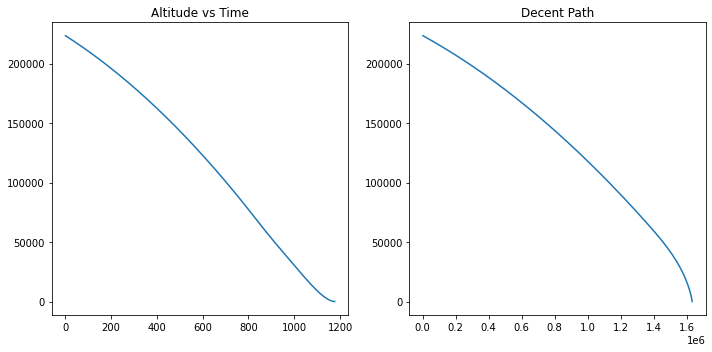

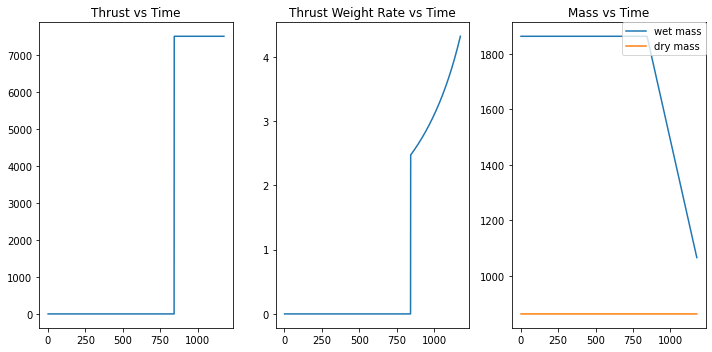

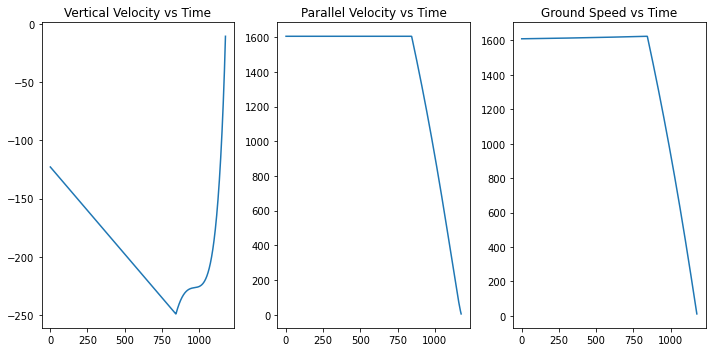

In [18]:
H = gradient(altitude)
print("Calculated engine ignition altitude is",H)
visualize(blank_simulate(H,pv,vv,altitude,wet_mass))